In [ ]:
import os
import torch
import pandas as pd
import scanpy as sc
from SPHERE.preprocess import *
from SPHERE.SPHERE import *
from SPHERE.utils import *
import numpy as np
import anndata
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
random_seed = 2022
fix_seed(random_seed)

## P22 100*100 barcodes

In [ ]:
adata_st = sc.read_h5ad('./P22_100_st.h5ad')
print(adata_st)
adata_sc = sc.read_h5ad('./P22_100_sc.h5ad')
print(adata_sc)
adata = anndata.concat([adata_st, adata_sc], label="batch", keys=['st', 'sc'])
adata.layers["counts"] = adata.X.copy()
lsi(adata, use_highly_variable=False, n_components=201)
adata_st.obsm['feat'] = adata[adata.obs['batch'] == 'st'].obsm['X_lsi'].copy()
adata_sc.obsm['feat'] = adata[adata.obs['batch'] == 'sc'].obsm['X_lsi'].copy()

AnnData object with n_obs × n_vars = 9215 × 28944
    obs: 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_peaks', 'nFeature_peaks', 'RNA_clusters', 'ATAC_clusters'
    obsm: 'X_pca', 'X_umap', 'spatial'
AnnData object with n_obs × n_vars = 23788 × 28944
    obs: 'Class', 'MajorType', 'SubType', 'region', 'cell_type'


In [3]:
adata_st, adata_sc = construct_neighbor_graph_decon(adata_st, adata_sc, loc_neighbors=14, gene_neighbors=8)

In [ ]:
onehot_df = pd.get_dummies(adata_sc.obs['cell_type'])
categories_ordered = adata_sc.obs['cell_type'].value_counts().index.tolist()
onehot_df = onehot_df[categories_ordered]
onehot_matrix = onehot_df.astype(int).values 
adata_sc.obsm['label'] = pd.DataFrame(onehot_matrix,columns=np.array(adata_sc.obs['cell_type'].value_counts().index.values),index=adata_sc.obs_names)

In [5]:
model = SPHERE(adata_st, device=device, learning_rate=3e-4, epochs=1600
                    , data_sc=adata_sc, lambda_recon=9, lambda_kl=2.4, lambda_spa_recon=0.4, lambda_fea_recon=0.3, deconvolution = True)


/home/yuzhuohan/workspace/ATAC/our/code_rep/SPHERE/preprocess.py:148: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  return torch.sparse.FloatTensor(indices, values, shape)


In [6]:
output = model.train_decon()
pre = output['pre']

  0%|          | 0/1600 [00:00<?, ?it/s]/home/yuzhuohan/miniconda3/envs/SPHERE/lib/python3.8/site-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
100%|██████████| 1600/1600 [01:56<00:00, 13.76it/s]

Model training finished!



In [7]:
pre.index = adata_st.obs_names
min_prop = 0.01
pre[pre < min_prop] = 0
row_sum = pre.sum(axis=1)                 
nonzero  = row_sum != 0                   
pre.loc[nonzero] = pre.loc[nonzero].div(row_sum[nonzero], axis=0)
adata_st.obs[pre.columns] = pre.values

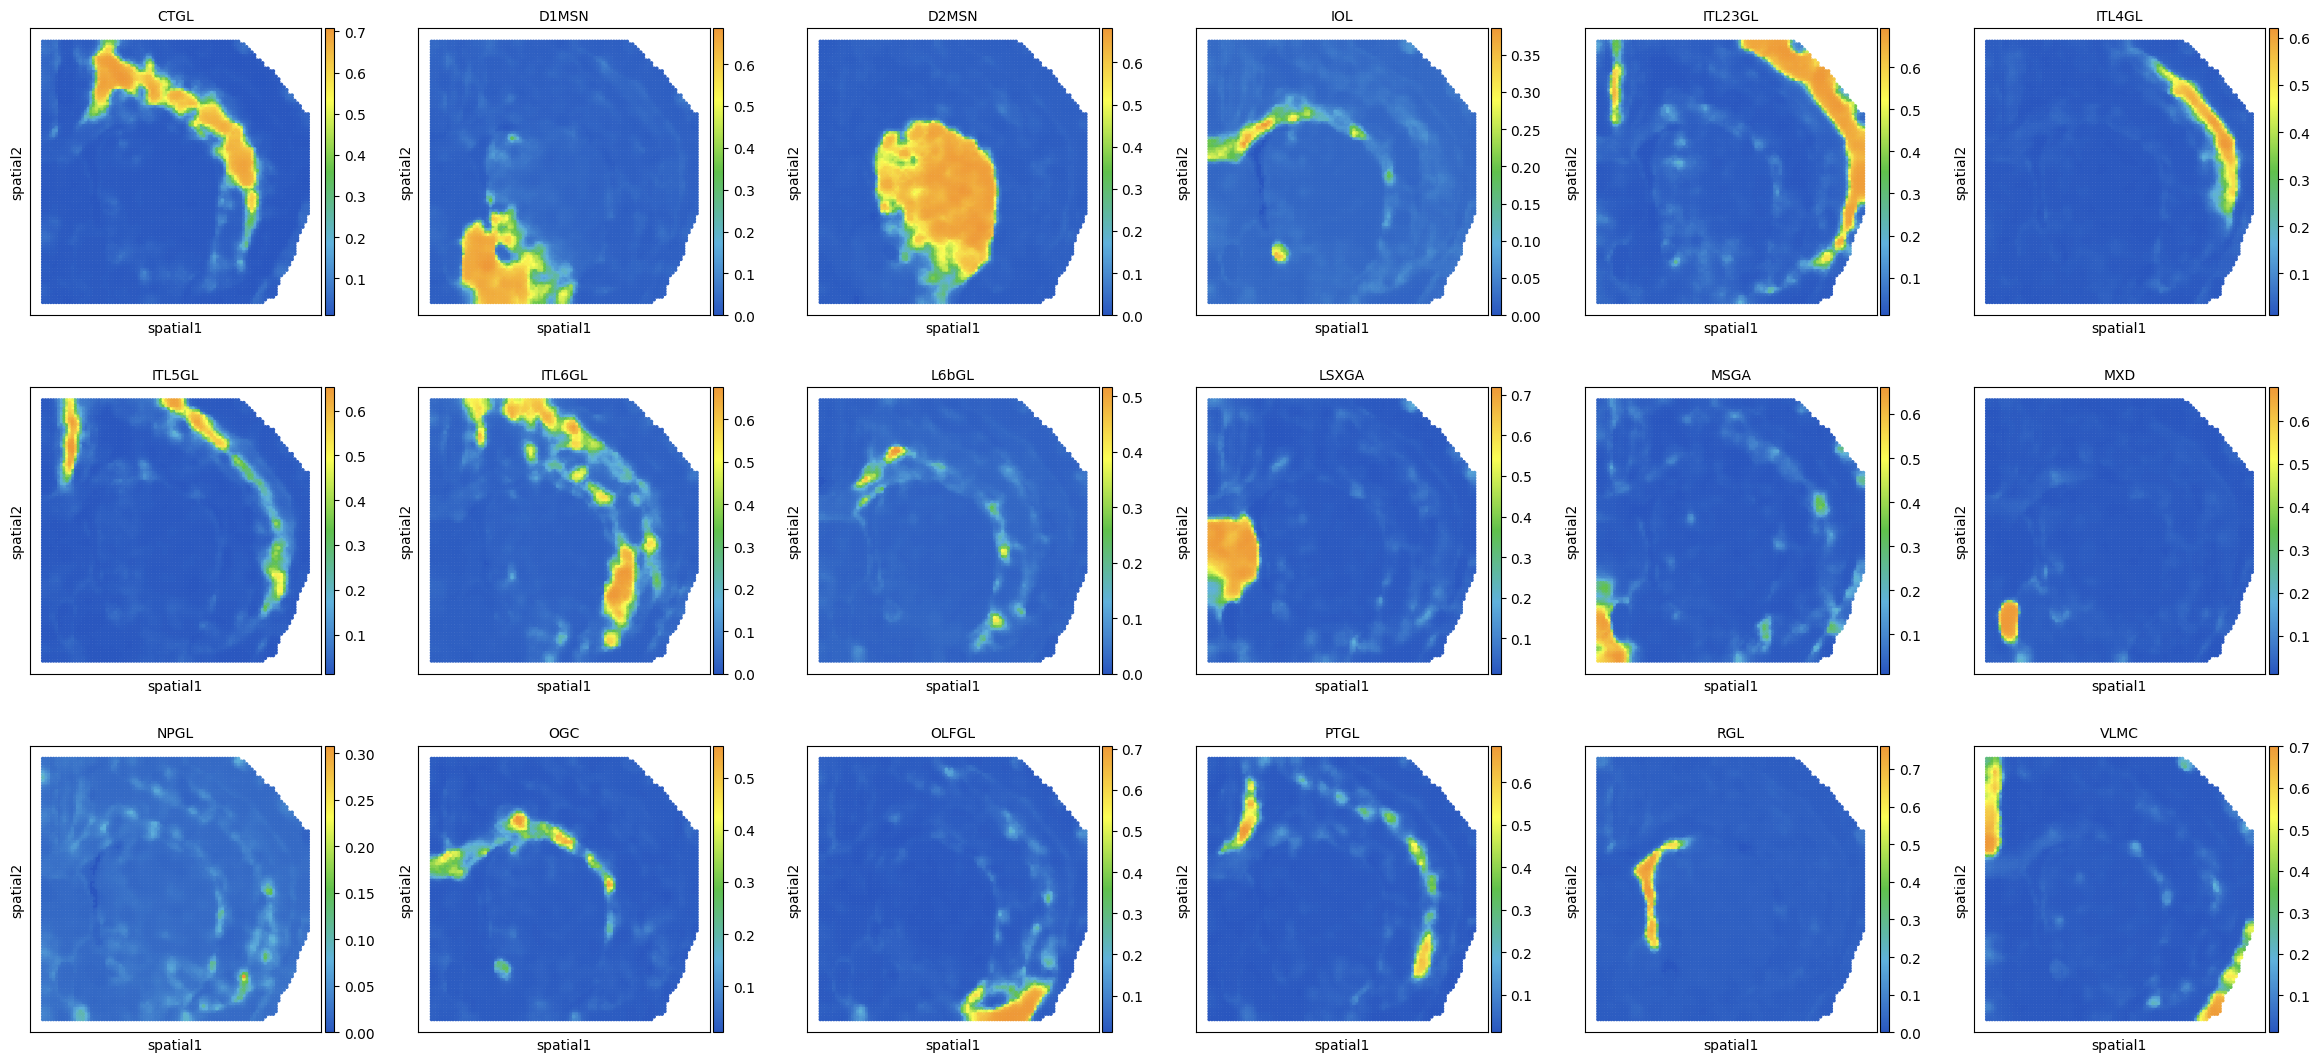

In [10]:
from matplotlib.colors import LinearSegmentedColormap
clist=['#2956BF','#5FB1DC','#60C14C','#FBFE55','#EE9938']
newcmp = LinearSegmentedColormap.from_list('chaos',clist)

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.serif'] = ['Arial']
sc.settings.set_figure_params(dpi=50,dpi_save=300,facecolor='white',fontsize=10,vector_friendly=True,figsize=(3.9,4))
sc.settings.verbosity = 3

sc.pl.embedding(adata_st,color=sorted(pre.columns[:20]),basis='spatial',ncols=6,s=30,cmap=newcmp)

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

DefaulfColorPalette = [
    "#5BB444", "#6F94E6", "#B6D7E4", "#A8A8D8", "#F1B145", "#F09336",
    "#BFFD5B", "#7FE069", "#98BB93", "#E2478F","#F9D849","#742AA7","#A1FCD1","#242467","#7A8B4B",
    "#D7C384","#696969","#63CEA3"
]
custom_cmap = mcolors.ListedColormap(DefaulfColorPalette)

def plot_frac_results(predict, cell_type_list, coordinates, cmap, color_dict=None):
    coordinates.columns = ['coor_X', 'coor_Y']
    labels = cell_type_list
    num_types = len(labels)
    
    if color_dict is not None:
        colors = [color_dict[i] for i in cell_type_list]
    else:
        if num_types <= 10:
            colors = plt.rcParams["axes.prop_cycle"].by_key()['color'][:num_types]
        else:
            import matplotlib
            cmap = plt.get_cmap(cmap, num_types)
            colors = [matplotlib.colors.to_hex(c) for c in cmap(range(num_types))]

    sizes = np.array(predict)
    x_positions = coordinates['coor_X'].values
    y_positions = coordinates['coor_Y'].values
    fig, ax = plt.subplots(figsize=(10, 10))
    

    for i in range(predict.shape[0]):
       ax.pie(sizes[i], colors=colors, center=(x_positions[i], y_positions[i]), radius=0.5, wedgeprops=dict(width=0.5))

    fontsize = max(predict.shape[0] / 100, 4)
    fontsize = min(fontsize, 1)
    
    plt.axis("equal")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

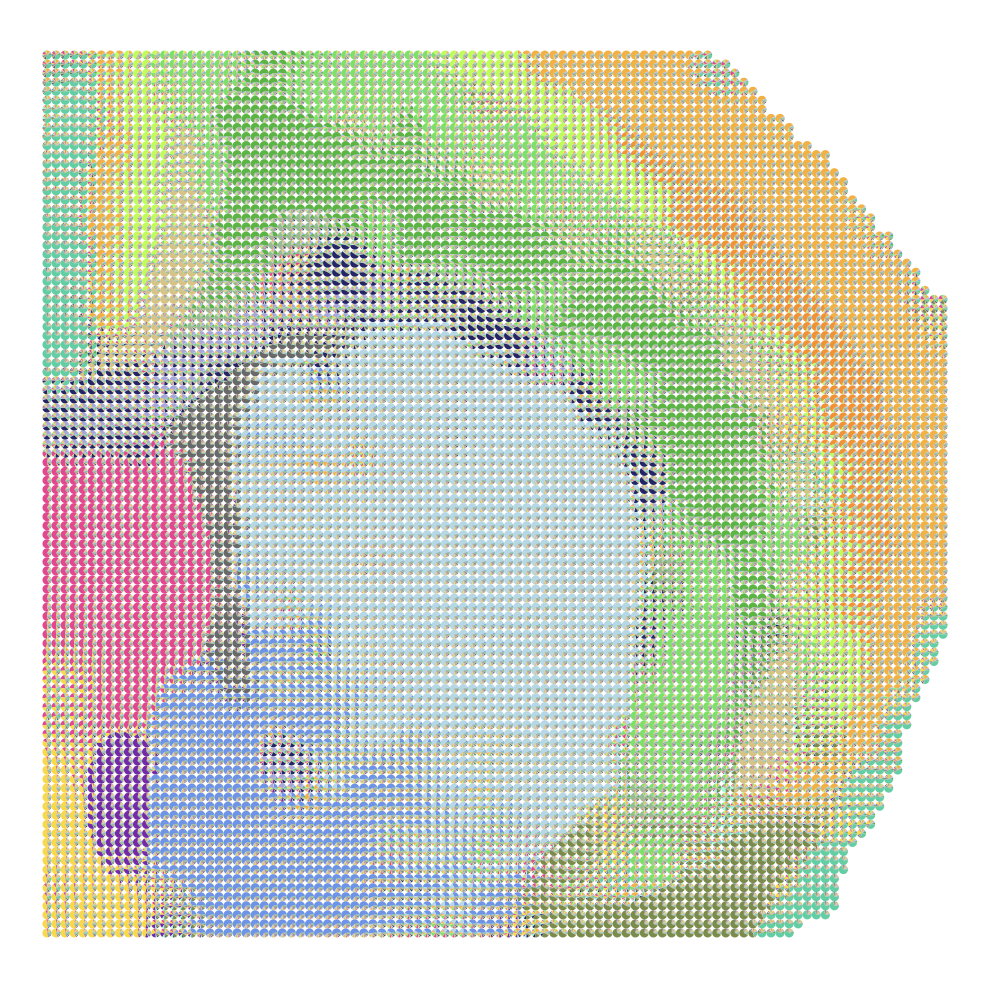

In [12]:
value_counts = adata_sc.obs['cell_type'].value_counts(normalize=True)
unique_labels = np.unique(value_counts.index)
pre=pre.loc[:,sorted(pre.columns[:20])]
decon = pd.DataFrame(np.array(pre), columns=pre.columns)
predict=np.array(decon)
cell_type_list=list(decon.columns)

data = adata_st.obsm['spatial']
coordinates = pd.DataFrame(data, columns=['Column1', 'Column2'])
plot_frac_results(predict, cell_type_list, coordinates, cmap=custom_cmap, color_dict=None)